### Implementing Mathworks Battery Cycle Life Prediction Using Deep Learning in Python

Portions of the text and descriptions in this notebook are adapted from MathWorks documentation examples:<br>
https://www.mathworks.com/help/predmaint <br>
Used under MathWorks example code license.<br>

References:
- [Mathworks Battery Cycle Life Prediction Using Deep Learning](https://www.mathworks.com/help/deeplearning/ug/battery-cycle-life-prediction-using-deep-learning.html)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('battery_cycle_data.csv')

In [3]:
df.head(5)

,BatteryIndex,CycleIndex,I,V,T,Qd
0,0,0,0.542759,2.123264,32.083302,6.003815e-07
1,0,0,0.848635,2.151546,32.082854,6.003815e-07
2,0,0,1.200086,2.192398,32.082429,6.003815e-07
3,0,0,1.550636,2.239513,32.081930,6.003815e-07
4,0,0,1.850152,2.283407,32.081520,6.003815e-07


"Visualize the data characteristics by creating a plot of current, voltage, and temperature measurements for one full cycle of the first battery in the data."

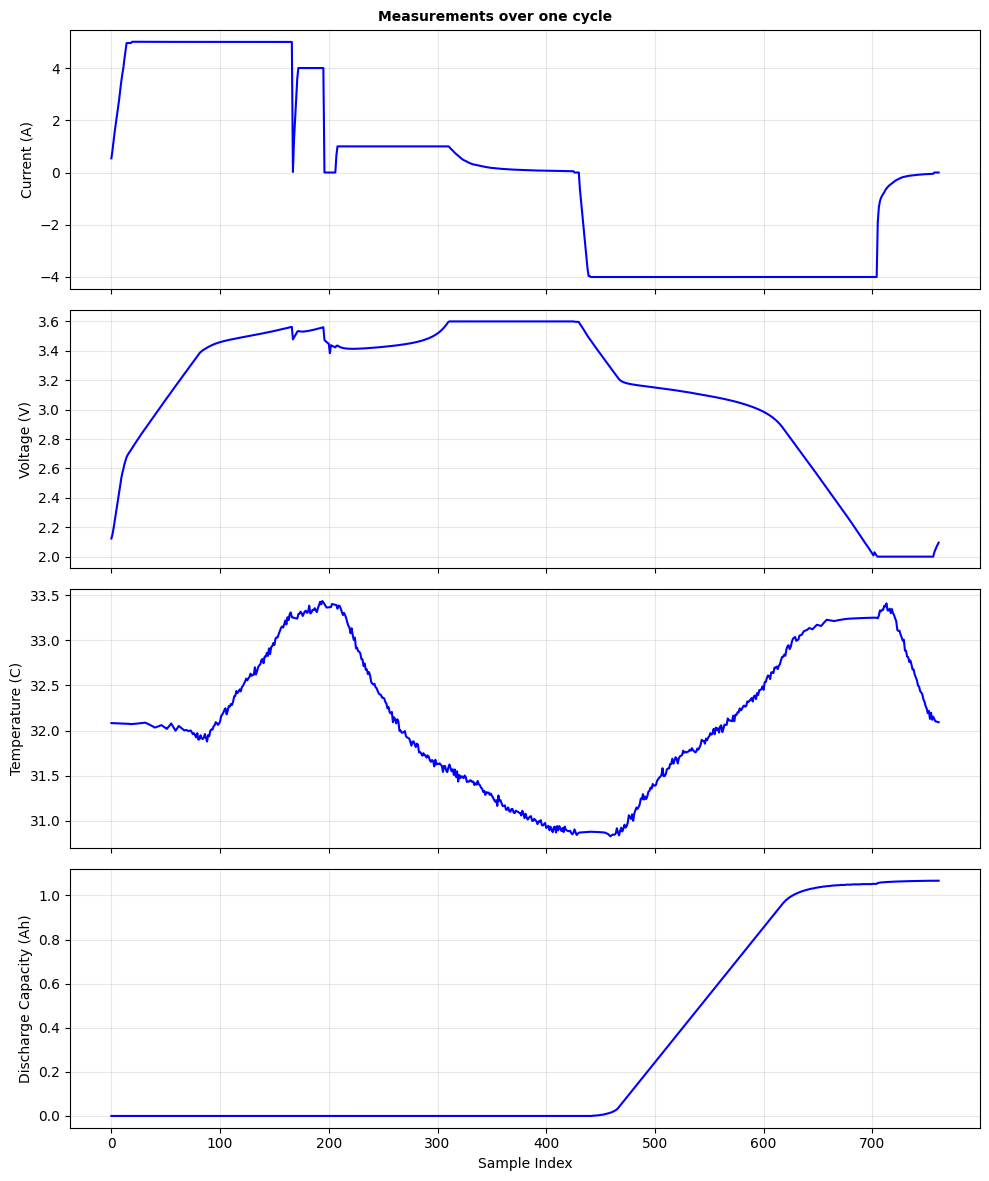

In [ ]:
battery_measurements = df[
    (df['BatteryIndex'] == 0) & 
    (df['CycleIndex'] == 0)
].copy()

fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Measurements over one cycle', fontsize=10, fontweight='bold')

battery_measurements['I'].plot(ax=axes[0], color='b', linewidth=1.5)
axes[0].set_ylabel('Current (A)')
axes[0].grid(True, alpha=0.3)

battery_measurements['V'].plot(ax=axes[1], color='b', linewidth=1.5)
axes[1].set_ylabel('Voltage (V)')
axes[1].grid(True, alpha=0.3)

battery_measurements['T'].plot(ax=axes[2], color='b', linewidth=1.5)
axes[2].set_ylabel('Temperature (C)')
axes[2].grid(True, alpha=0.3)

battery_measurements['Qd'].plot(ax=axes[3], color='b', linewidth=1.5)
axes[3].set_ylabel('Discharge Capacity (Ah)')
axes[3].set_xlabel('Sample Index')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

"In the preceding plot, positive current indicates a charging process while negative current indicates a discharge operation. The battery is fully charged when it reaches 3.6V and fully discharged when it reaches 2V. Further, the batteries are subjected to different fast charging policies in this data set to understand their degradation profile across time and load."

### Extract Battery Discharge Measurements

Since all batteries have different charging policies but identical discharge voltage range, you use only the discharge portions of the signals in this example. 
Extract the measurements corresponding to the discharge portion of the cycle using the hExtractDischargeData helper function. Plot the discharge data for the first cycle of the first battery.

In [ ]:
discharge_data = df[df['I'] < 0].copy()
discharge_battery_measurements = discharge_data[
    (discharge_data['BatteryIndex'] == 0) & 
    (discharge_data['CycleIndex'] == 0)
].copy()

In [6]:
discharge_battery_measurements.head()

,BatteryIndex,CycleIndex,I,V,T,Qd
431,0,0,-0.639688,3.582515,30.872307,0.000006
432,0,0,-1.080069,3.572184,30.873091,0.000006
433,0,0,-1.520453,3.561411,30.873842,0.000047
434,0,0,-1.960487,3.549908,30.874582,0.000047
435,0,0,-2.360555,3.539153,30.875329,0.000047


In [7]:
discharge_battery_measurements['V'].max()

np.float64(3.5825152)

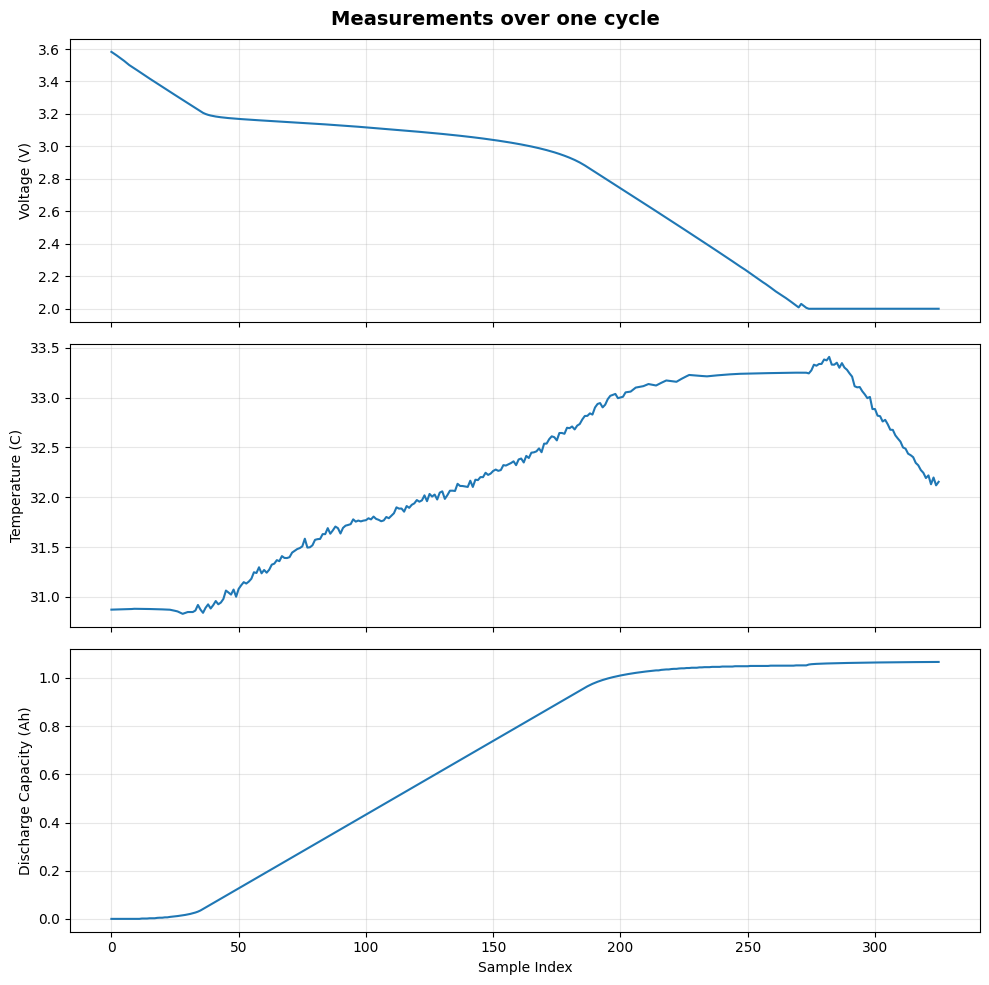

In [ ]:
cycle = discharge_battery_measurements.reset_index(drop=True)
cycle.index.name = "Sample Index"

fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
fig.suptitle('Measurements over one cycle', fontsize=14, fontweight='bold')

axes[0].plot(cycle.index, cycle['V'], linewidth=1.5)
axes[0].set_ylabel('Voltage (V)') 
axes[0].grid(True, alpha=0.3)

axes[1].plot(cycle.index, cycle['T'], linewidth=1.5)
axes[1].set_ylabel('Temperature (C)') 
axes[1].grid(True, alpha=0.3)

axes[2].plot(cycle.index, cycle['Qd'], linewidth=1.5)
axes[2].set_ylabel('Discharge Capacity (Ah)')
axes[2].set_xlabel('Sample Index') 
axes[2].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

"Since the batteries in this data set are tested with different charging policies, some cycles are completed sooner than others. Therefore, cycle time cannot be used to compare charge and temperature across batteries. The voltage range is used as the reference instead of time because the discharge time varies based on the connected load and the health of the batteries. The charge and temperature measurements are then interpolated over this voltage range. Use hLinearInterpolation function to interpolate voltage, temperature and discharge capacity measurements onto a uniformly sampled 900 point voltage range between 3.6V and 2V. The interpolated data is returned as a 30x30 array for each measurement to form a 2-D representation for each battery discharge cycle. Note that reshaping the 900x1 vector to a 30x30 matrix leads to the convolutional network searching for spatial relation between each column of the matrix. This example assumes that such a relationship might exist across the various cycles and attempts to leverage it if present. The image below shows the temperature and voltage data for a single cycle of a cell being interpolated to 900 points and then being reshaped to a 30x30. The 2-D representation the measurement of each cycle converts the sensor measurements into an image format for the CNN layers."

In [ ]:
from BatteryDeepLearningHelpers import linearInterpolation

V_interpol, T_interpol, Qd_interpol = linearInterpolation(discharge_data)

print(f"There were {len(V_interpol)} battery cycles")

There were 41240 battery cycles


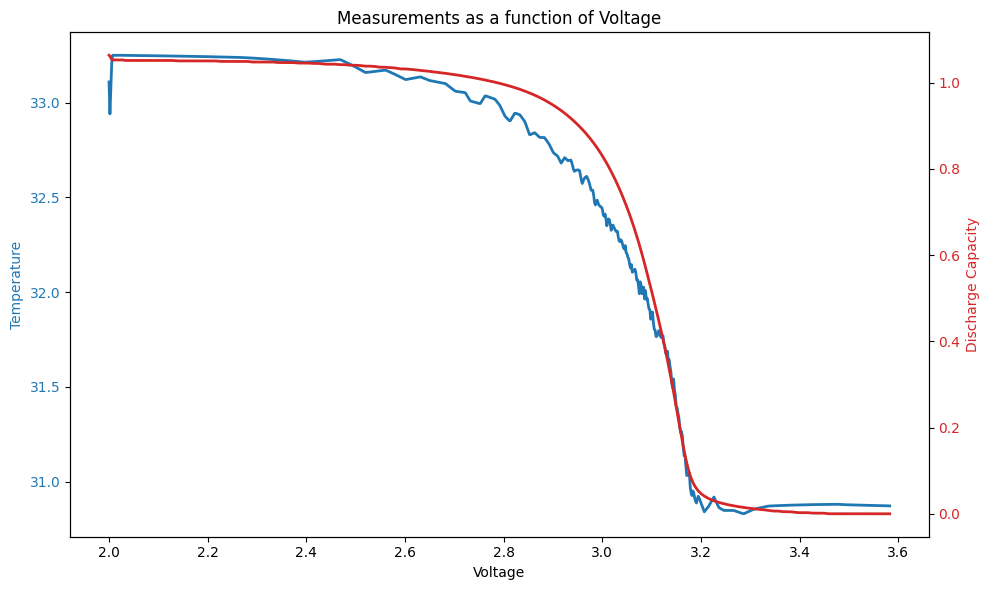

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

battery_idx = 0
cycle_idx = 0
key = (battery_idx, cycle_idx)

voltage_data = V_interpol[key].reshape(900, 1).flatten()
temp_data = T_interpol[key].reshape(900, 1).flatten()
qd_data = Qd_interpol[key].reshape(900, 1).flatten()

fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Voltage')
ax1.set_ylabel('Temperature', color=color1)
ax1.plot(voltage_data, temp_data, color=color1, linewidth=2)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Discharge Capacity', color=color2)
ax2.plot(voltage_data, qd_data, color=color2, linewidth=2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Measurements as a function of Voltage')
fig.tight_layout()
plt.show()

^ not exactly like the one in mathworks, could be how the data is being interpolated

"For the 2-D Convolution Neural Network layers in the deep network, the 30x30 matrix of interpolated voltage, discharge capacity and temperature are reshaped to a form a 30x30x3 matrix for each cycle. This is like the RGB channels of an image. To minimize the range of the estimated remaining cycles, the expected output signal is normalized by dividing by 2000 (the maximum life of the battery in the data). The data from 30 batteries is used for training, 5 batteries for validation and 5 batteries for testing of the deep neural network. Use the hreshapeData helper function to create the 30x30x3 data set for each cycle. This function outputs the measurement data (trainData) and the RUL data (trainRulData) to use as labels for each case."

In [11]:
from BatteryDeepLearningHelpers import prepare_battery_data_for_cnn

train_data, train_rul_data, val_data, val_rul_data, test_data, test_rul_data = prepare_battery_data_for_cnn(
    V_interpol, T_interpol, Qd_interpol, total_batteries=40
)

Filtering training data
Filtering validation data
Filtering test data
reshaping training data
reshaping validation data
reshaping test data
Training data shape: (30706, 30, 30, 3)
Training RUL data shape: (30706,)
Validation data shape: (5479, 30, 30, 3)
Validation RUL data shape: (5479,)
Test data shape: (5055, 30, 30, 3)
Test RUL data shape: (5055,)


In [ ]:
#print(train_data[0])

#### Define Network Architecture

"Defining the architecture of convolutional neural network includes selecting the types of layers, selecting the number of layers, and tuning the hyperparameters until satisfactory performance is achieved against test data. In this section, the types of layers and number of layers are specified. To create your deep neural network structure, define a set of successive network layers. Use a network structure with the following layers:"


- Image input layer — Treat the voltage, discharge capacity, temperature data as the three color channels of an input image and normalize the measurements to the range [0,1].
- 2-D convolutional layers — Each of these layers applies sliding convolutional filters to the image input. This example uses four hidden convolutional layers. This number of layers, which was selected through trial and error, gives the best result while keeping a reasonable training time.
- Layer normalization layers — Each convolutional layer is followed by a layer normalization layer, which speeds up the training of the network and reduces the sensitivity to network initialization.
- ReLU layers — Each layer normalization layer is followed by a nonlinear activation function, which performs a threshold operation to each element of the input.
- Pooling layers — The first two ReLU layers are followed by pooling layers, which reduce the size of the feature map. These layers remove redundant information and reduce the number of parameters to be learned in subsequent layers.
- Fully connected layer — At the end, ReLU layer is followed by a fully connected layer, which combines all of the learned features into a single output.

In [ ]:
from BatteryDeepLearningHelpers import compute_global_min_max
train_mins, train_maxs = compute_global_min_max(train_data)
print("Global channel mins:", train_mins)
print("Global channel maxs:", train_maxs)


Global channel mins: [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.48230398e-08
 4.19525107e-07 6.09769670e-03 1.87605548e-03 2.14682670e-02
 4.29107649e-02 1.43132527e-01 3.44818010e-01 4.78722989e-01
 5.56500286e-01 6.06895975e-01 6.40067699e-01 6.63122018e-01
 6.80897519e-01 6.95377074e-01 7.07498936e-01 7.17746345e-01
 7.26964264e-01 7.38458091e-01 7.50052300e-01 7.56861736e-01
 7.60593470e-01 7.63207790e-01 7.64775832e-01 2.47053139e-02
 2.30248943e-02 7.68951210e-01]
Global channel maxs: [42.75870532 42.76498859 42.780212   42.77891346 42.81451411 42.865308
 42.92065449 42.91908252 42.9617097  43.01116102 43.10319787 42.98211989
 43.02085082 42.990704   42.95191171 42.83819787 42.76401813 42.73580578
 42.73325883 42.69573015 42.71860266 42.80859573 42.83208933 42.87631589
 42.92246922 42.92726682 42.92873668 42.91805285 42.90475481 43.03631925]


In [ ]:
from BatteryDeepLearningHelpers import normalize_with_global_min_max
train_data = normalize_with_global_min_max(train_data, train_mins, train_maxs)
val_data = normalize_with_global_min_max(val_data, train_mins, train_maxs)   
test_data = normalize_with_global_min_max(test_data, train_mins, train_maxs) 

In [ ]:
# reshaping for later 
train_data = np.transpose(train_data, (0, 3, 1, 2))
val_data = np.transpose(val_data, (0, 3, 1, 2))
test_data = np.transpose(test_data, (0, 3, 1, 2))
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(30706, 3, 30, 30)
(5479, 3, 30, 30)
(5055, 3, 30, 30)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BatteryCNN(nn.Module):
    def __init__(self):
        super(BatteryCNN, self).__init__()
        
        # Input image size: [3, 30, 30]
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm([8, 30, 30])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # output: [8, 15, 15]

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.norm2 = nn.LayerNorm([16, 15, 15])
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # output: [16, 7, 7]

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.norm3 = nn.LayerNorm([32, 7, 7])

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm4 = nn.LayerNorm([32, 7, 7])

        self.conv5 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm5 = nn.LayerNorm([32, 7, 7])

        # Final fully connected layer
        self.fc = nn.Linear(32 * 7 * 7, 1)

    def forward(self, x):

        x = F.relu(self.norm1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.norm2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.norm3(self.conv3(x)))
        x = F.relu(self.norm4(self.conv4(x)))
        x = F.relu(self.norm5(self.conv5(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


#### Define Network Hyperparameters and Train Network

"In this section, define the hyperparameters for the network specified in the previous section. Selecting hyperparameters, such as the learning rate or batch size, is generally through trial and error with the goal of finding the best set for the selected network and the data set to achieve satisfactory performance from the network.

For this example, use the Adam (adaptive moment estimation) optimizer, which has a fast computation time and few parameters to tune. Configure the solver to:

- Use a mini-batch size of 256 observations.
- Train on the entire data set 50 times, which the number of training epochs.
- Shuffle the data set before each epoch to improve convergence.
- Use a learning rate of 0.001, which achieves a good balance between convergence and overshooting.
- Validate the network periodically to identify when the network is overfitting the training data."

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.1 

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train_tensor = torch.tensor(train_data, dtype=torch.float32)
y_train_tensor = torch.tensor(train_rul_data, dtype=torch.float32).view(-1, 1)  # make sure it's shape (N, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [22]:
model = BatteryCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [23]:
X_val_tensor = torch.tensor(val_data, dtype=torch.float32)
y_val_tensor = torch.tensor(val_rul_data, dtype=torch.float32).view(-1, 1)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            val_loss += criterion(outputs, y_val).item() * X_val.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/50 - Train Loss: 0.0643 - Val Loss: 0.0274
Epoch 2/50 - Train Loss: 0.0406 - Val Loss: 0.0265
Epoch 3/50 - Train Loss: 0.0369 - Val Loss: 0.0232
Epoch 4/50 - Train Loss: 0.0174 - Val Loss: 0.0019
Epoch 5/50 - Train Loss: 0.0103 - Val Loss: 0.0027
Epoch 6/50 - Train Loss: 0.0097 - Val Loss: 0.0018
Epoch 7/50 - Train Loss: 0.0097 - Val Loss: 0.0017
Epoch 8/50 - Train Loss: 0.0088 - Val Loss: 0.0058
Epoch 9/50 - Train Loss: 0.0096 - Val Loss: 0.0016
Epoch 10/50 - Train Loss: 0.0085 - Val Loss: 0.0011
Epoch 11/50 - Train Loss: 0.0080 - Val Loss: 0.0078
Epoch 12/50 - Train Loss: 0.0136 - Val Loss: 0.0024
Epoch 13/50 - Train Loss: 0.0088 - Val Loss: 0.0016
Epoch 14/50 - Train Loss: 0.0072 - Val Loss: 0.0050
Epoch 15/50 - Train Loss: 0.0073 - Val Loss: 0.0016
Epoch 16/50 - Train Loss: 0.0073 - Val Loss: 0.0026
Epoch 17/50 - Train Loss: 0.0055 - Val Loss: 0.0024
Epoch 18/50 - Train Loss: 0.0048 - Val Loss: 0.0078
Epoch 19/50 - Train Loss: 0.0046 - Val Loss: 0.0036
Epoch 20/50 - Train L

In [25]:
X_test_tensor = torch.tensor(val_data, dtype=torch.float32)
y_test_tensor = torch.tensor(val_rul_data, dtype=torch.float32).view(-1, 1)
val_dataset = TensorDataset(X_val_tensor, y_test_tensor)

test_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

#### Evaluate Performance of Trained Model

Use the trained model to predict the remaining cycle life for testData. The values must be rescaled back to the original RUL range to make it easier to visualize the performance.

In [ ]:
model.eval()

test_preds = []

with torch.no_grad():
    for X_test_batch, _ in test_loader:
        X_test_batch = X_test_batch.to(device)
        outputs = model(X_test_batch)
        test_preds.append(outputs.cpu())

test_preds = torch.cat(test_preds, dim=0).squeeze().numpy()

test_preds_rescaled = test_preds * 2000
test_true_rescaled = y_test_tensor.squeeze().numpy() * 2000


In [ ]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

rmse = root_mean_squared_error(test_true_rescaled, test_preds_rescaled)
mae = mean_absolute_error(test_true_rescaled, test_preds_rescaled)
r2 = r2_score(test_true_rescaled, test_preds_rescaled)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R^2: {r2:.4f}")


Test RMSE: 163.45
Test MAE: 109.39
Test R²: 0.7502


Ideally, the scatter plot should have all data points along the diagonal with a narrow confidence band.

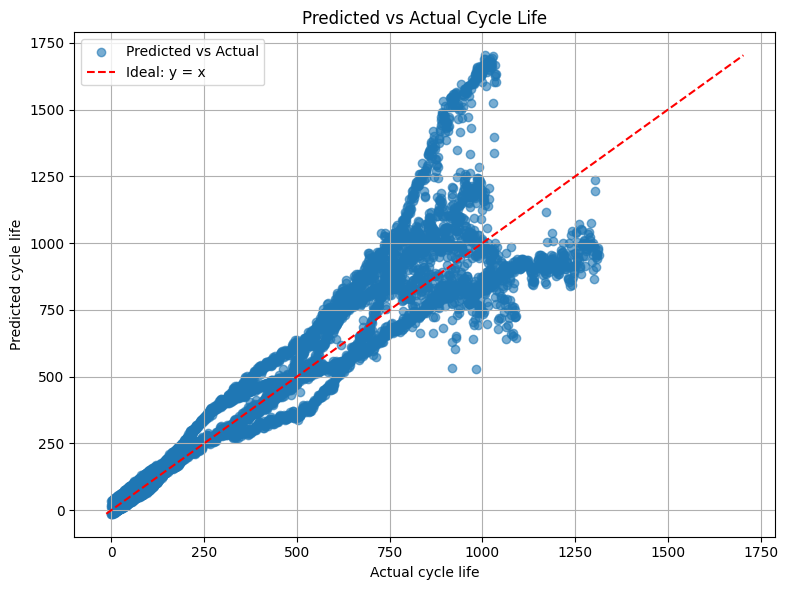

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(test_true_rescaled, test_preds_rescaled, alpha=0.6, label="Predicted vs Actual")

min_val = min(test_true_rescaled.min(), test_preds_rescaled.min())
max_val = max(test_true_rescaled.max(), test_preds_rescaled.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal: y = x')

plt.title("Predicted vs Actual Cycle Life")
plt.xlabel("Actual cycle life")
plt.ylabel("Predicted cycle life")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
